# Physics-Informed Neural Networks for ODEs
## Solving the Damped Pendulum Without Discretization

**Physics-Informed Neural Networks (PINNs)** train neural networks to satisfy both governing equations
and boundary/initial conditions simultaneously—no discretization required.

| Traditional Methods | PINNs |
|-------------------|-------|
| Require discretization | **Meshfree**: continuous solution |
| Fixed grid resolution | **Adaptive**: query anywhere |
| Black-box outputs | **Differentiable**: embed in optimization |
| Ignore sparse data | **Data-efficient**: fuse physics with observations |

**Navigation:** [Jump to Control Panel](#control-panel)

In [ ]:
import marimo as mo
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

try:
    from scipy.integrate import solve_ivp
except ImportError:
    solve_ivp = None

try:
    import matplotlib.animation as animation
except ImportError:
    animation = None

---
## 1. The Physical System

The damped pendulum is governed by:

$$\frac{d^2\theta}{dt^2} + \beta \frac{d\theta}{dt} + \frac{g}{l}\sin(\theta) = 0$$

**Notation:** $\theta(t)$ = angle, $\beta$ = damping, $g$ = gravity (9.81 m/s²), $l$ = length (m)

**Initial Conditions:** $\theta(0) = \theta_0$, $\dot{\theta}(0) = \omega_0$

**Dynamical Regimes** (critical damping $\beta_c = 2\sqrt{g/l}$):
- **Underdamped** ($\beta < \beta_c$): Oscillations with decay
- **Critically damped** ($\beta = \beta_c$): Fastest return to equilibrium
- **Overdamped** ($\beta > \beta_c$): Slow exponential decay

In [ ]:
@mo.cache
def reference_solution(t_min, t_max, u0, v0, beta, g, l, n_eval):
    """Numerical solution using scipy for comparison"""
    if solve_ivp is None:
        return None, None

    def ode(t, y):
        theta, omega = y
        return [omega, -beta * omega - (g / l) * np.sin(theta)]

    sol = solve_ivp(ode, (t_min, t_max), [u0, v0], dense_output=True)
    t_ref = np.linspace(t_min, t_max, n_eval)
    u_ref = sol.sol(t_ref)[0]
    return t_ref, u_ref

---
## 2. The PINN Formulation

### Core Idea

Approximate $\theta(t)$ with neural network $u_\phi(t)$ by minimizing:

$$\mathcal{L}_{\text{total}} = w_{\text{phys}} \mathcal{L}_{\text{physics}} + w_{\text{IC}} \mathcal{L}_{\text{IC}}$$

where derivatives are computed via **automatic differentiation**.

### 2.1 Neural Network Architecture

A configurable shallow network (tunable hidden layers and width, tanh activations) maps time $t$ to angle $\theta(t)$.

In [ ]:
class PINN(nn.Module):
    def __init__(self, hidden_width=32, num_layers=2):
        super().__init__()
        layers = [nn.Linear(1, hidden_width), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_width, hidden_width), nn.Tanh()])
        layers.append(nn.Linear(hidden_width, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

### 2.2 Physics Residual & Loss Functions

**Physics Loss** at collocation points $\{t_i\}$:

$$\mathcal{L}_{\text{physics}} = \frac{1}{N}\sum_{i=1}^N \left[\frac{\partial^2 u}{\partial t^2} + \beta \frac{\partial u}{\partial t} + \frac{g}{l}\sin(u)\right]^2$$

**Initial Condition Loss**

$$\mathcal{L}_{\text{IC}} = |u(0) - \theta_0|^2 + |\frac{\partial u}{\partial t}(0) - \omega_0|^2$$

In [ ]:
def physics_residual(model, t, g, l, beta):
    """Compute ODE residual using automatic differentiation"""
    u = model(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                               create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t),
                                create_graph=True, retain_graph=True)[0]
    return u_tt + beta * u_t + (g / l) * torch.sin(u)

### 2.3 Training Loop

The training loop samples collocation points, computes both loss terms with adjustable weights,
and updates network parameters via gradient descent.

In [ ]:
@mo.persistent_cache
def train_model(t_min, t_max, u0, v0, g, l, beta, n_collocation, epochs, lr,
                physics_weight, ic_weight, hidden_width, num_layers, print_every,
                frame_every, make_gif, device_type):
    device = torch.device(device_type)
    model = PINN(hidden_width=hidden_width, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Collocation points
    t_col = torch.linspace(t_min, t_max, n_collocation, device=device).view(-1, 1)
    t_col.requires_grad_(True)

    # Initial condition point
    t_ic = torch.tensor([[0.0]], device=device, requires_grad=True)
    u_ic = torch.tensor([[u0]], device=device)
    v_ic = torch.tensor([[v0]], device=device)

    # Test points
    t_test = torch.linspace(t_min, t_max, 500, device=device).view(-1, 1)

    # Reference solution
    t_ref, u_ref = reference_solution(t_min, t_max, u0, v0, beta, g, l, 500)

    losses = []
    animation_snapshots = []

    # Training loop
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()

        # Physics loss
        residual = physics_residual(model, t_col, g, l, beta)
        phys_loss = loss_fn(residual, torch.zeros_like(residual))

        # IC loss
        u_pred = model(t_ic)
        u_t_pred = torch.autograd.grad(u_pred, t_ic, grad_outputs=torch.ones_like(u_pred),
                                      create_graph=True, retain_graph=True)[0]
        ic_loss = loss_fn(u_pred, u_ic) + loss_fn(u_t_pred, v_ic)

        # Weighted total loss
        total_loss = physics_weight * phys_loss + ic_weight * ic_loss
        total_loss.backward()
        optimizer.step()

        losses.append([total_loss.item(), phys_loss.item(), ic_loss.item()])

        if epoch % print_every == 0:
            print(f"Epoch {epoch}/{epochs} | Loss={total_loss:.3e} | "
                  f"Phys={phys_loss:.3e} | IC={ic_loss:.3e}")
        if make_gif and epoch % frame_every == 0:
            with torch.no_grad():
                animation_snapshots.append(
                    {
                        "epoch": epoch,
                        "u_pred": model(t_test).cpu().numpy().flatten(),
                    }
                )

    # Final predictions
    with torch.no_grad():
        u_pred = model(t_test).cpu().numpy().flatten()

    return {
        'model': model,
        'losses': np.array(losses),
        't_test': t_test.cpu().numpy().flatten(),
        'u_pred': u_pred,
        't_col': t_col.detach().cpu().numpy().flatten(),
        't_ref': t_ref,
        'u_ref': u_ref,
        'animation_snapshots': animation_snapshots,
        'make_gif': make_gif,
    }

<a id="control-panel"></a>
### 2.4 Tune Parameters & Start Training

Adjust physical, numerical, and training parameters below. Training results are cached.

**Tuning tips:**
- Keep physical parameters fixed unless the exercise explicitly asks you to change them.
- Increase collocation points to enforce physics better; this usually improves accuracy but increases runtime.
- Increase epochs while losses are still decreasing; stop when improvement plateaus.
- Lower learning rate if training is unstable/oscillatory; raise it slightly if convergence is too slow.
- Rebalance loss weights when one constraint dominates (PDE residual vs IC mismatch).
- Increase network width/depth for harder dynamics; larger models are slower and harder to optimize.

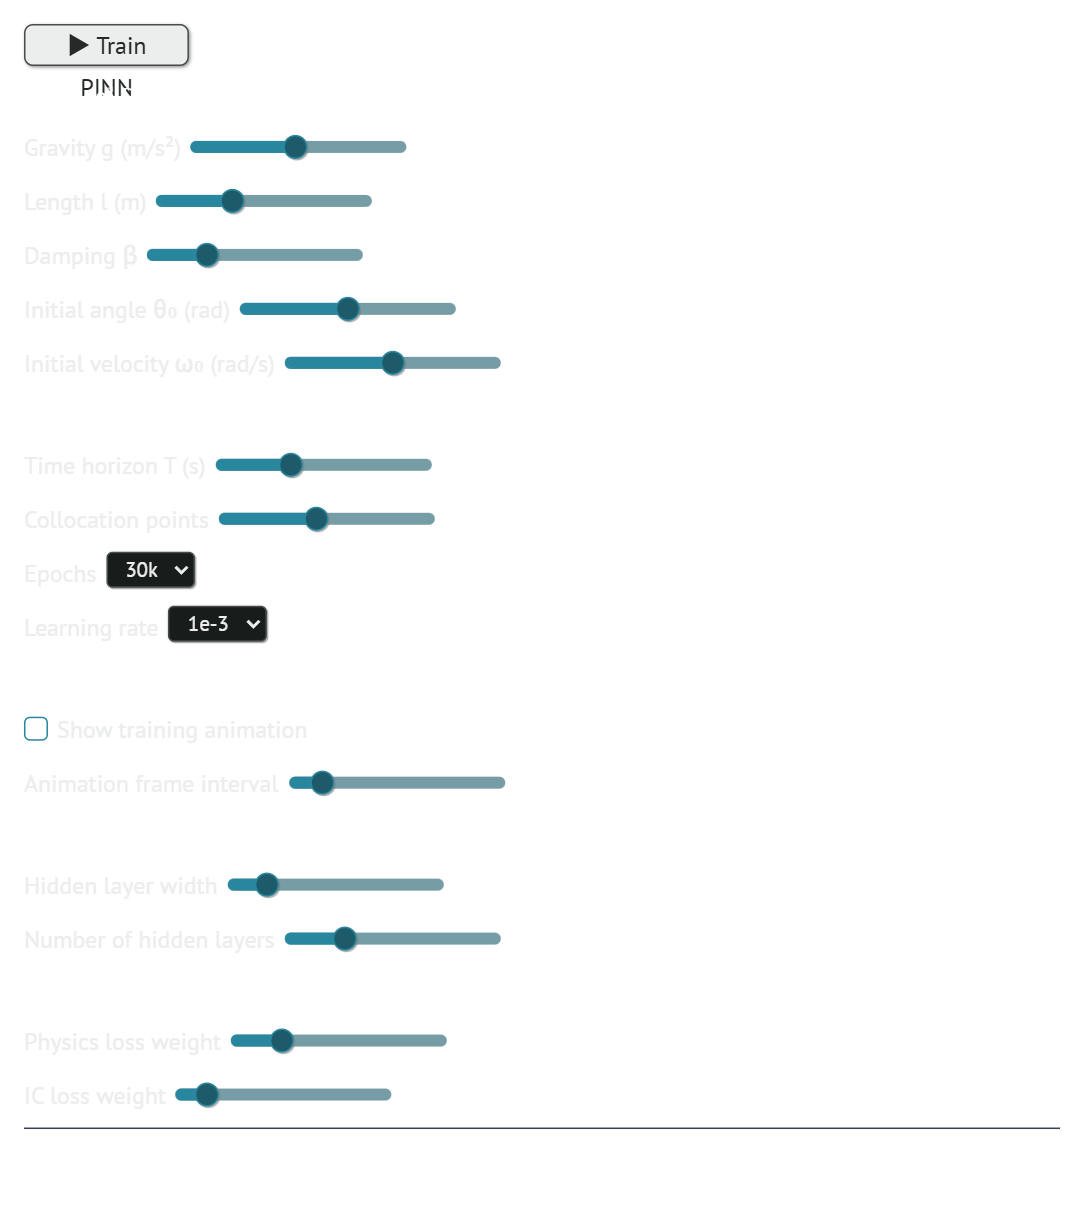

In [ ]:
# Physical parameters
g_slider = mo.ui.slider(5.0, 15.0, value=9.81, step=0.1, label="Gravity g (m/s²)")
l_slider = mo.ui.slider(0.5, 2.0, value=1.0, step=0.1, label="Length l (m)")
beta_slider = mo.ui.slider(0.0, 2.0, value=0.5, step=0.05, label="Damping β")
u0_slider = mo.ui.slider(0.0, 3.14, value=float(torch.pi/2), step=0.1, label="Initial angle θ₀ (rad)")
v0_slider = mo.ui.slider(-2.0, 2.0, value=0.0, step=0.1, label="Initial velocity ω₀ (rad/s)")

# Time domain
t_max_slider = mo.ui.slider(5.0, 20.0, value=10.0, step=1.0, label="Time horizon T (s)")
n_collocation = mo.ui.slider(100, 1000, value=500, step=50, label="Collocation points")

# Training settings
epochs_dropdown = mo.ui.dropdown({"5k": 5000, "10k": 10000, "20k": 20000, "30k": 30000},
                                  value="30k", label="Epochs")
lr_dropdown = mo.ui.dropdown({"1e-4": 1e-4, "5e-4": 5e-4, "1e-3": 1e-3, "5e-3": 5e-3},
                              value="1e-3", label="Learning rate")
make_gif_checkbox = mo.ui.checkbox(label="Show training animation", value=False)
frame_interval = mo.ui.slider(50, 500, value=100, step=50, label="Animation frame interval")

# Loss weights
physics_weight = mo.ui.slider(0.0, 10.0, value=2.0, step=0.1, label="Physics loss weight")
ic_weight = mo.ui.slider(0.0, 10.0, value=1.0, step=0.1, label="IC loss weight")

# Network architecture
hidden_width_slider = mo.ui.slider(16, 128, value=32, step=8, label="Hidden layer width")
num_layers_slider = mo.ui.slider(1, 5, value=2, step=1, label="Number of hidden layers")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

control_panel = mo.vstack([
    mo.md("#### Physical Parameters"),
    g_slider, l_slider, beta_slider, u0_slider, v0_slider,
    mo.md("#### Domain & Training"),
    t_max_slider, n_collocation, epochs_dropdown, lr_dropdown,
    mo.md("#### Visualization"),
    make_gif_checkbox, frame_interval,
    mo.md("#### Network Architecture"),
    hidden_width_slider, num_layers_slider,
    mo.md("#### Loss Weights"),
    physics_weight, ic_weight,
    mo.md("---"),
    mo.md(f"**Device:** `{device}`"),
])

train_button = mo.ui.run_button(label="▶ Train PINN")

mo.vstack([train_button, control_panel])

In [ ]:
mo.stop(not train_button.value, mo.md("_Click **▶ Train PINN** to begin_"))

results = train_model(
    t_min=0.0, t_max=t_max_slider.value,
    u0=u0_slider.value, v0=v0_slider.value,
    g=g_slider.value, l=l_slider.value, beta=beta_slider.value,
    n_collocation=n_collocation.value,
    epochs=epochs_dropdown.value, lr=lr_dropdown.value,
    physics_weight=physics_weight.value, ic_weight=ic_weight.value,
    hidden_width=hidden_width_slider.value, num_layers=num_layers_slider.value,
    print_every=100,
    frame_every=frame_interval.value,
    make_gif=make_gif_checkbox.value,
    device_type=device.type,
)

/home/honghui/miniconda3/envs/sciml/lib/python3.13/site-packages/torch/autograd/graph.py:865: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:330.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 100/30000 | Loss=2.199e+00 | Phys=9.637e-02 | IC=2.006e+00
Epoch 200/30000 | Loss=2.158e+00 | Phys=1.060e-01 | IC=1.946e+00
Epoch 300/30000 | Loss=2.119e+00 | Phys=1.127e-01 | IC=1.893e+00
Epoch 400/30000 | Loss=2.023e+00 | Phys=1.231e-01 | IC=1.777e+00
Epoch 500/30000 | Loss=1.806e+00 | Phys=1.712e-01 | IC=1.464e+00
Epoch 600/30000 | Loss=1.703e+00 | Phys=1.978e-01 | IC=1.308e+00
Epoch 700/30000 | Loss=1.595e+00 | Phys=2.319e-01 | IC=1.131e+00
Epoch 800/30000 | Loss=1.533e+00 | Phys=2.478e-01 | IC=1.038e+00
Epoch 900/30000 | Loss=1.473e+00 | Phys=2.550e-01 | IC=9.627e-01
Epoch 1000/30000 | Loss=1.402e+00 | Phys=2.657e-01 | IC=8.703e-01
Epoch 1100/30000 | Loss=1.335e+00 | Phys=2.715e-01 | IC=7.918e-01
Epoch 1200/30000 | Loss=1.266e+00 | Phys=2.733e-01 | IC=7.194e-01
Epoch 1300/30000 | Loss=1.203e+00 | Phys=2.795e-01 | IC=6.444e-01
Epoch 1400/30000 | Loss=1.152e+00 | Phys=2.847e-01 | IC=5.828e-01
Epoch 1500/30000 | Loss=1.112e+00 | Phys=2.889e-01 | IC=5.339e-01
Epoch 1600/30000 | 

---
## 3. Results Analysis

Analyze solution accuracy, physics satisfaction, training dynamics, and phase space structure.

### 3.1 Solution Comparison

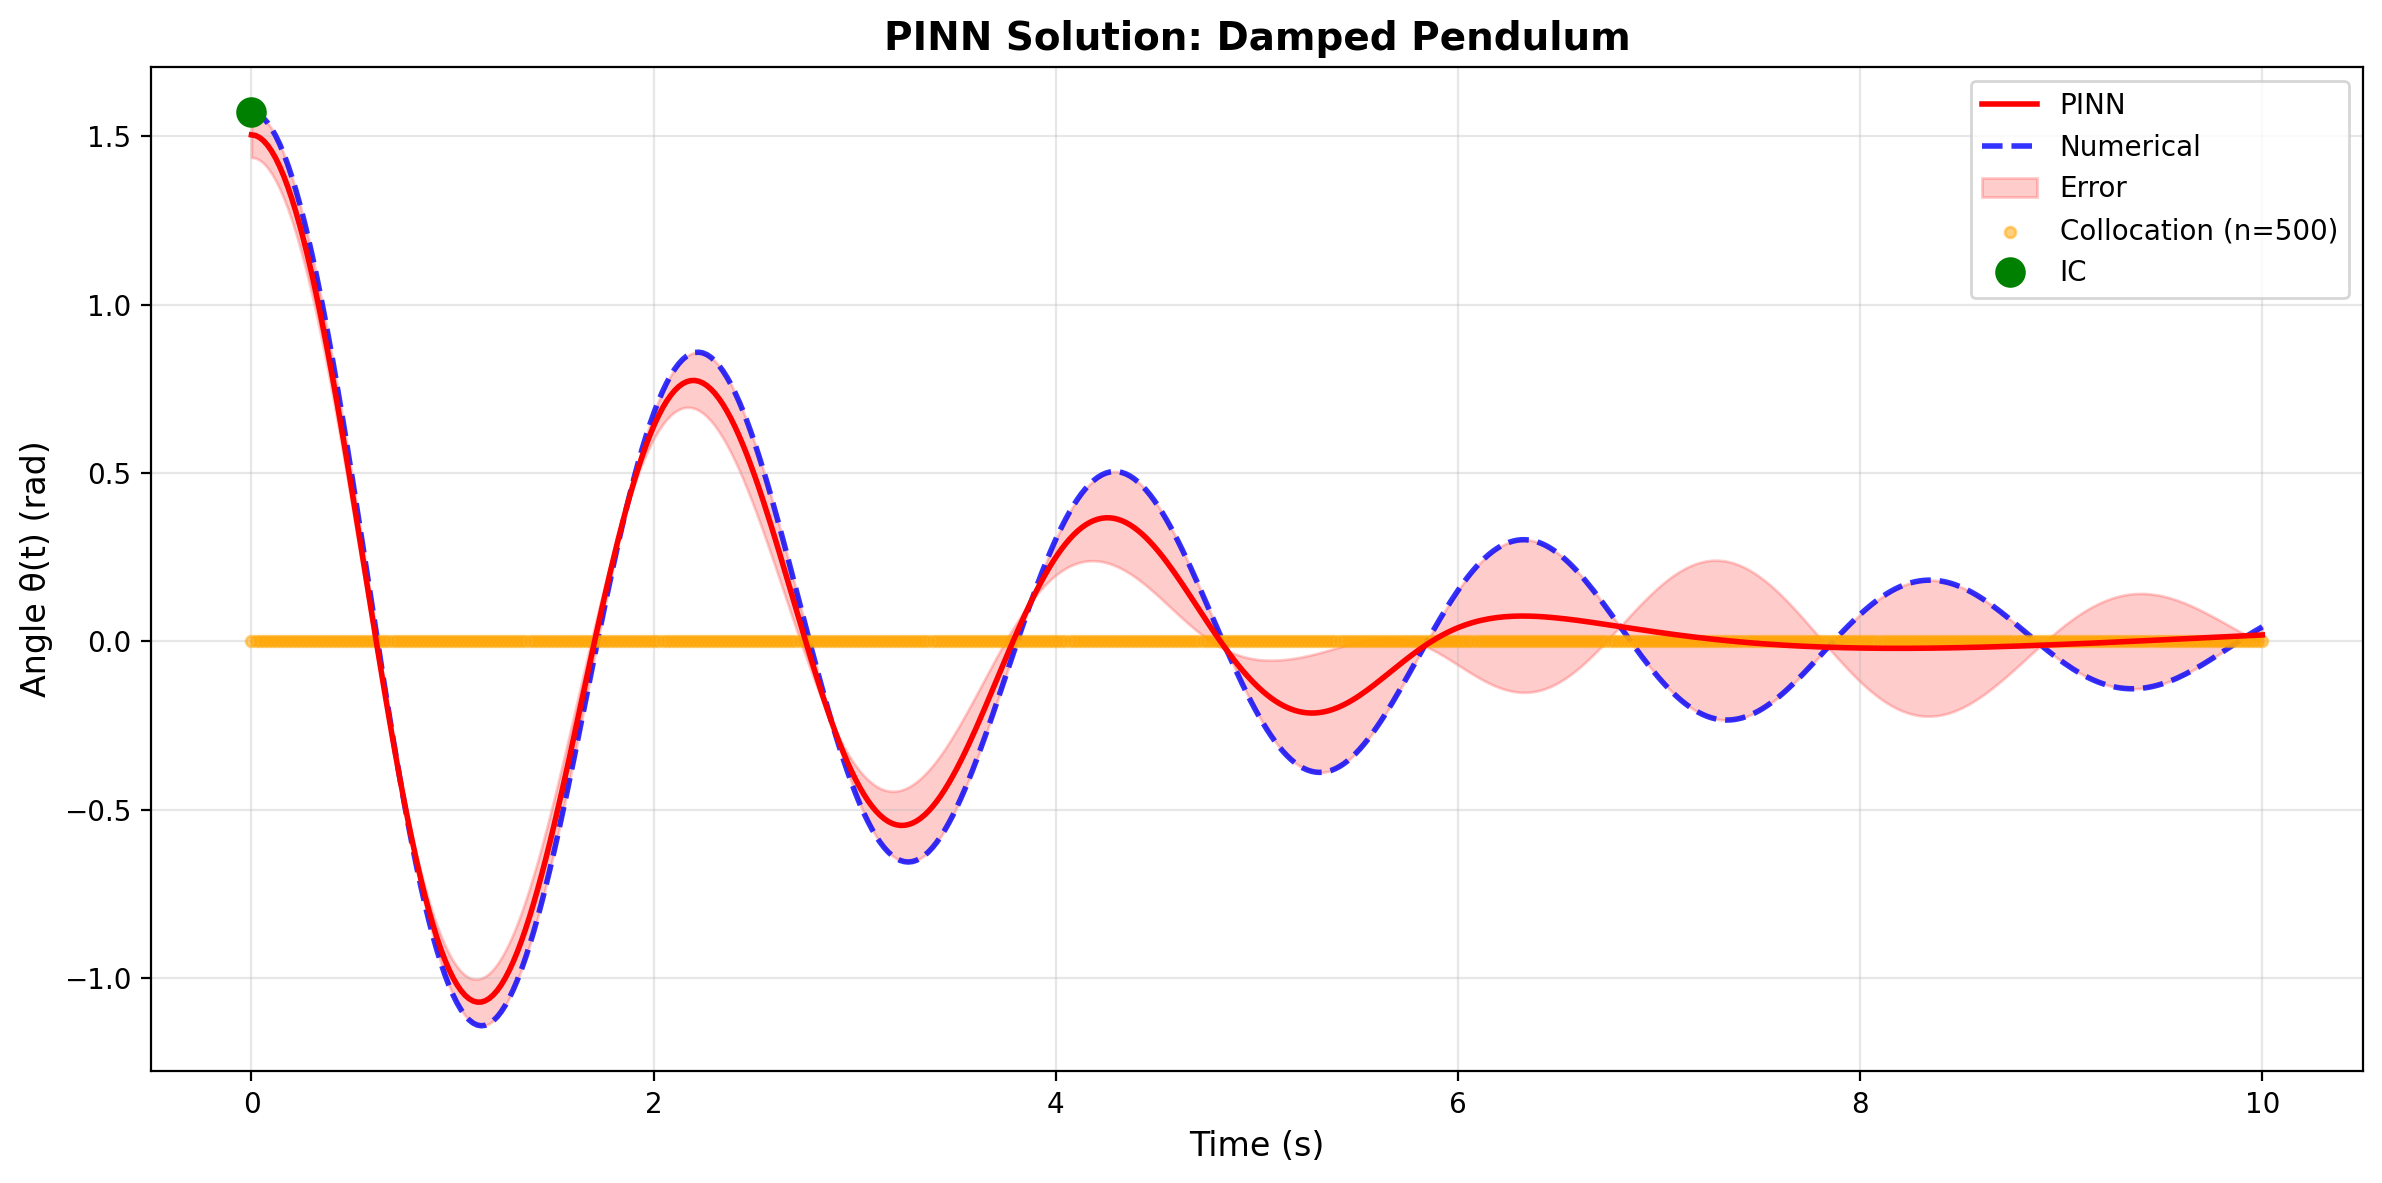

In [ ]:
snapshots = results.get("animation_snapshots", [])
if results.get("make_gif") and snapshots and animation is not None:
    try:
        _fig_anim, _ax_anim = plt.subplots(figsize=(12, 6))
        t_test = np.asarray(results["t_test"])
        t_col = np.asarray(results["t_col"])

        curve_arrays = [np.asarray(results["u_pred"])]
        if results["u_ref"] is not None:
            curve_arrays.append(np.asarray(results["u_ref"]))
        curve_arrays.extend(np.asarray(frame["u_pred"]) for frame in snapshots)
        all_values = np.concatenate(curve_arrays)
        y_min = float(all_values.min())
        y_max = float(all_values.max())
        pad = max(0.1 * (y_max - y_min), 1e-3)

        _ax_anim.set_xlim(float(t_test.min()), float(t_test.max()))
        _ax_anim.set_ylim(y_min - pad, y_max + pad)
        _ax_anim.set_xlabel("Time (s)", fontsize=12)
        _ax_anim.set_ylabel("Angle θ(t) (rad)", fontsize=12)
        _ax_anim.grid(True, alpha=0.3)

        _line_solution, = _ax_anim.plot([], [], "r-", linewidth=2, label="PINN")
        if results["u_ref"] is not None:
            _ax_anim.plot(results["t_ref"], results["u_ref"], "b--", linewidth=2, alpha=0.8, label="Numerical")
        _ax_anim.scatter(t_col, np.zeros_like(t_col), s=10, c="orange", alpha=0.35, label="Collocation")
        _ax_anim.plot(0, u0_slider.value, "go", markersize=8, label="IC")
        _epoch_text_solution = _ax_anim.text(0.02, 0.95, "", transform=_ax_anim.transAxes, va="top")
        _ax_anim.legend(loc="best")

        def _init_solution_anim():
            _line_solution.set_data([], [])
            _epoch_text_solution.set_text("")
            return _line_solution, _epoch_text_solution

        def _animate_solution_frame(i):
            frame = snapshots[i]
            _line_solution.set_data(t_test, frame["u_pred"])
            _epoch_text_solution.set_text(f"Training epoch: {frame['epoch']}")
            return _line_solution, _epoch_text_solution

        _solution_anim_obj = animation.FuncAnimation(
            _fig_anim,
            _animate_solution_frame,
            init_func=_init_solution_anim,
            frames=len(snapshots),
            interval=150,
            blit=True,
        )
        _video_html_solution = _solution_anim_obj.to_html5_video()
        plt.close(_fig_anim)
        solution_output = mo.Html(_video_html_solution)
    except Exception as e:
        solution_output = mo.md(f"_Animation rendering error: {e}_")
else:
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(results["t_test"], results["u_pred"], "r-", linewidth=2, label="PINN", zorder=3)

    if results["u_ref"] is not None:
        ax1.plot(results["t_ref"], results["u_ref"], "b--", linewidth=2, label="Numerical", alpha=0.8)
        error = np.abs(results["u_pred"] - results["u_ref"])
        ax1.fill_between(
            results["t_test"],
            results["u_pred"] - error,
            results["u_pred"] + error,
            alpha=0.2,
            color="red",
            label="Error",
        )

    ax1.scatter(
        results["t_col"],
        np.zeros_like(results["t_col"]),
        s=15,
        c="orange",
        alpha=0.5,
        label=f"Collocation (n={len(results['t_col'])})",
        zorder=2,
    )
    ax1.plot(0, u0_slider.value, "go", markersize=10, label="IC", zorder=4)

    ax1.set_xlabel("Time (s)", fontsize=12)
    ax1.set_ylabel("Angle θ(t) (rad)", fontsize=12)
    ax1.set_title("PINN Solution: Damped Pendulum", fontsize=14, fontweight="bold")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="best")
    plt.tight_layout()
    solution_output = fig1

solution_output

### 3.2 Physics Residual

The residual:

$$\ddot{u} + \beta\dot{u} + (g/l)\sin(u)$$

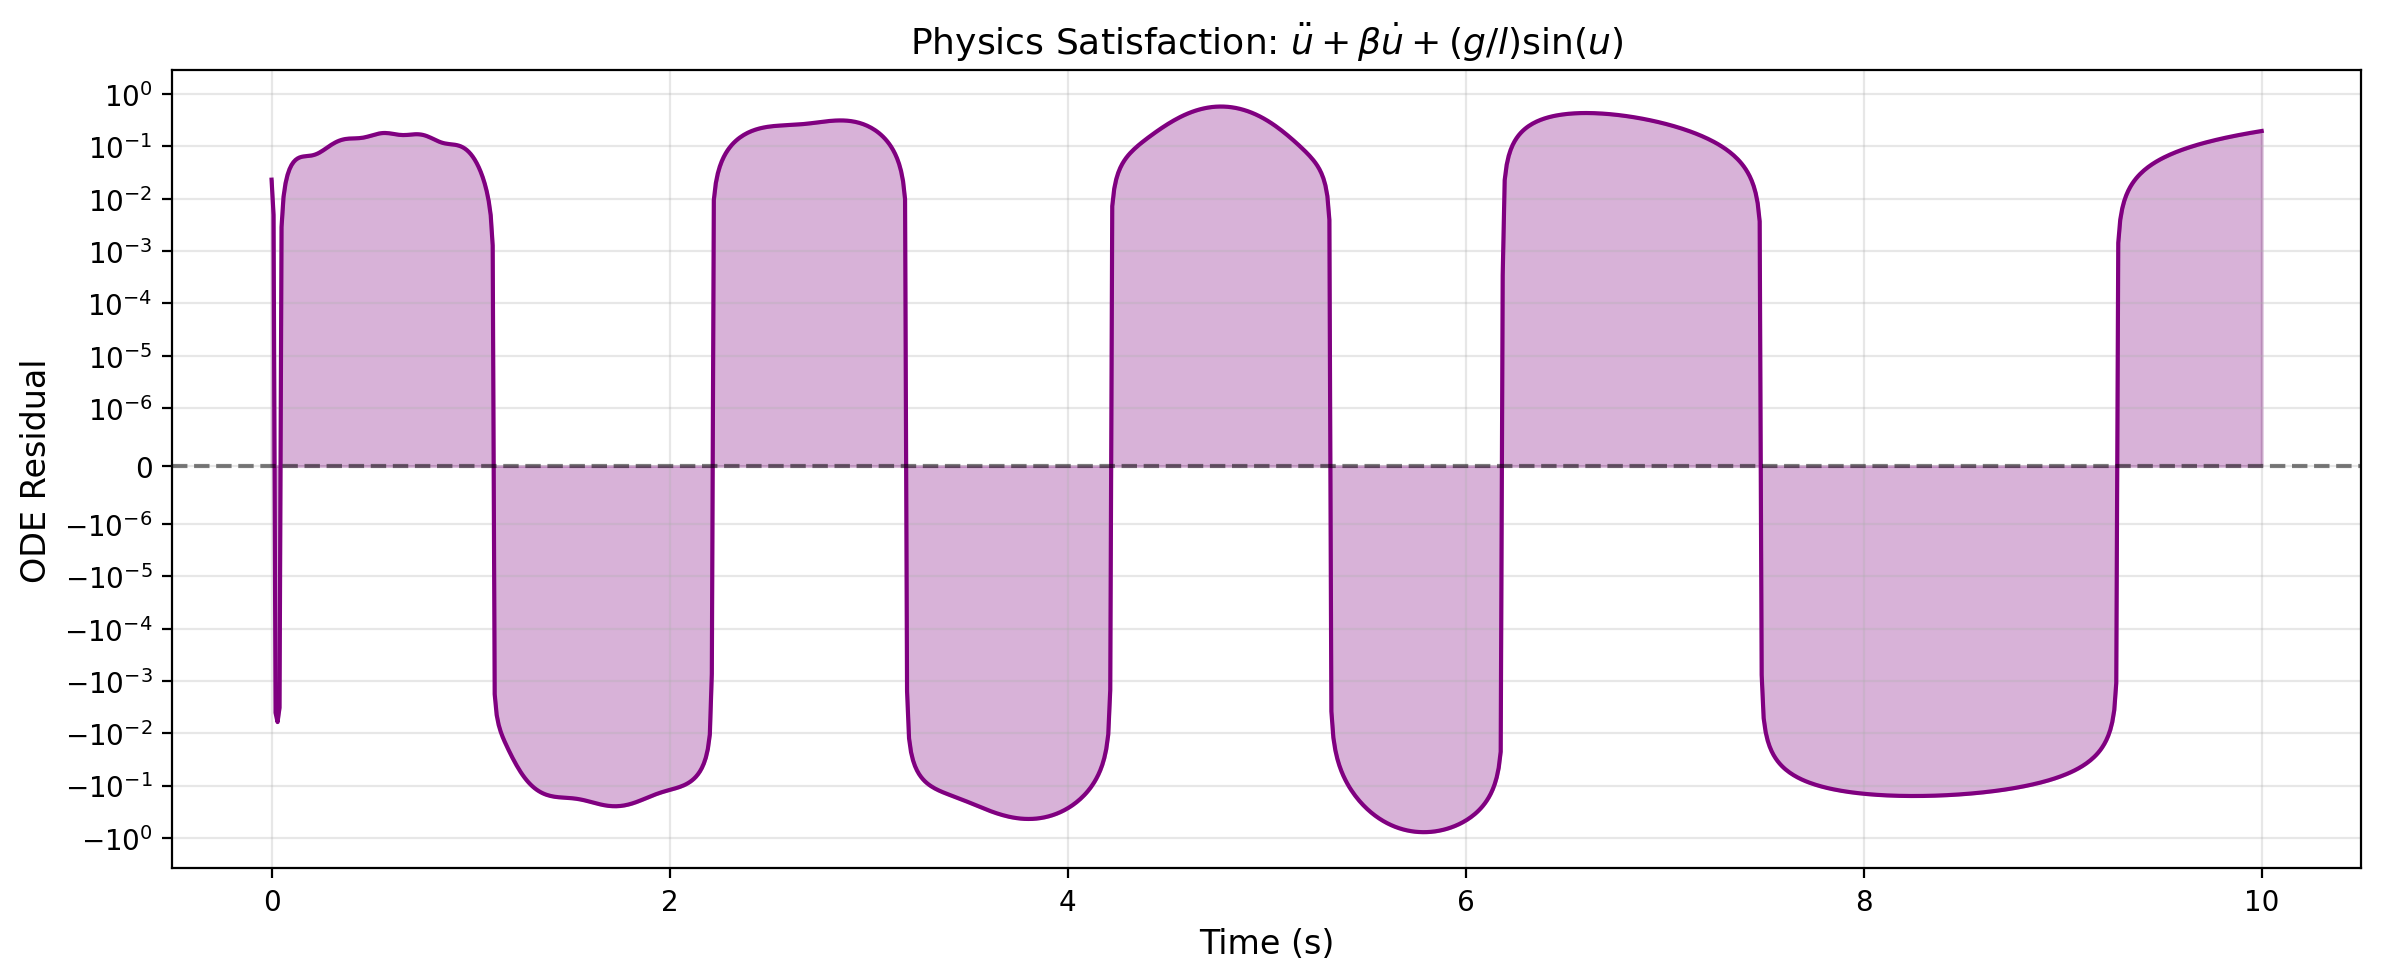

In [ ]:

t_fine = torch.linspace(0.0, t_max_slider.value, 1000, device=device).view(-1, 1)
t_fine.requires_grad_(True)
residual = physics_residual(results['model'], t_fine, g_slider.value,
                            l_slider.value, beta_slider.value).cpu().detach().numpy()

fig2, ax2 = plt.subplots(figsize=(12, 5))
ax2.plot(t_fine.cpu().detach().numpy(), residual, 'purple', linewidth=1.5)
ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
ax2.fill_between(t_fine.cpu().detach().numpy().ravel(), 0, residual.ravel(), alpha=0.3, color='purple')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('ODE Residual', fontsize=12)
ax2.set_title(r'Physics Satisfaction: $\ddot{u} + \beta\dot{u} + (g/l)\sin(u)$', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('symlog', linthresh=1e-6)
plt.tight_layout()
fig2

### 3.3 Training Dynamics

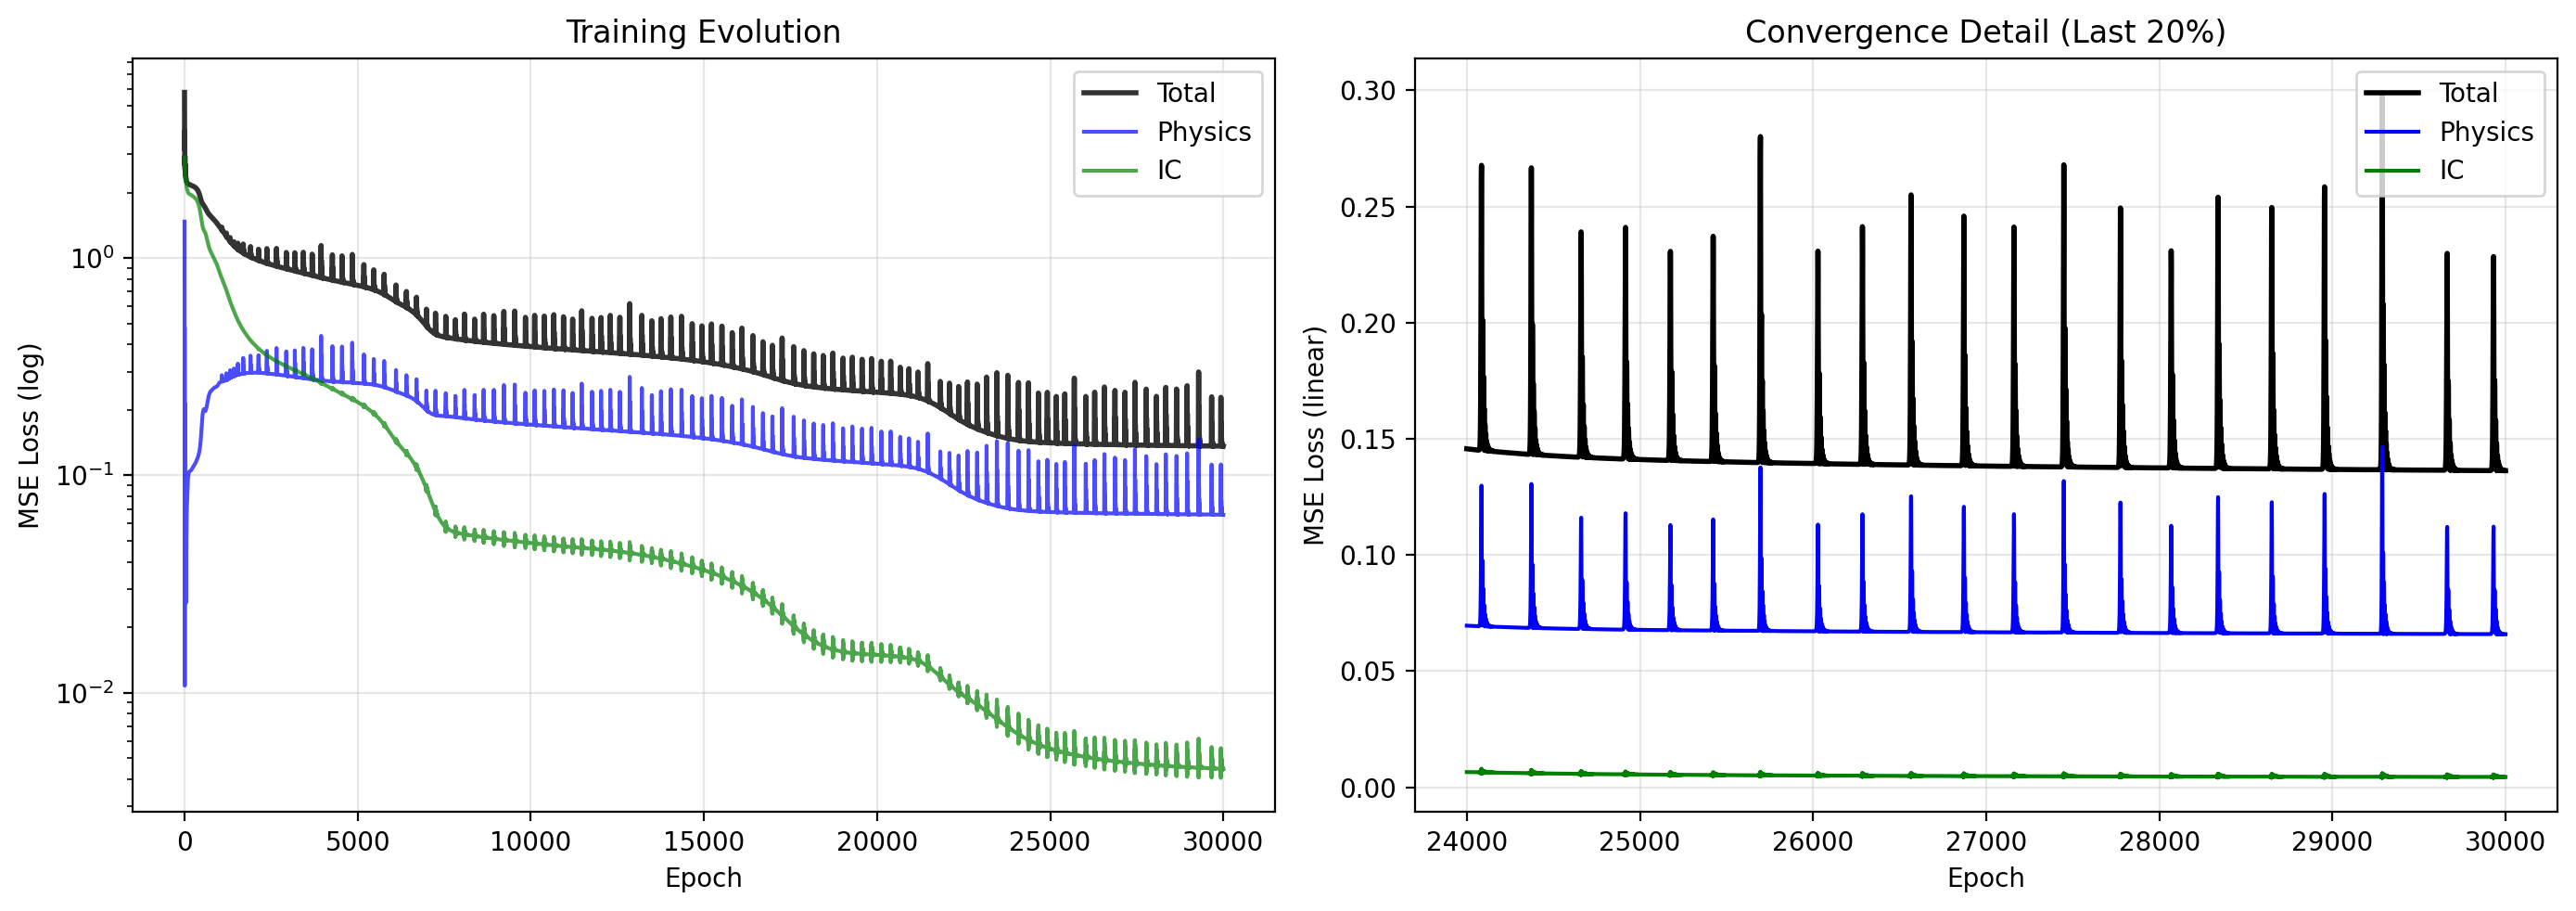

In [ ]:
losses = results['losses']

fig3, (ax_log, ax_lin) = plt.subplots(1, 2, figsize=(14, 5))

# Log scale
ax_log.plot(losses[:, 0], 'k-', linewidth=2, label='Total', alpha=0.8)
ax_log.plot(losses[:, 1], 'b-', linewidth=1.5, label='Physics', alpha=0.7)
ax_log.plot(losses[:, 2], 'g-', linewidth=1.5, label='IC', alpha=0.7)
ax_log.set_yscale('log')
ax_log.set_xlabel('Epoch')
ax_log.set_ylabel('MSE Loss (log)')
ax_log.set_title('Training Evolution')
ax_log.grid(True, alpha=0.3)
ax_log.legend()

# Linear scale (last 20%)
start_idx = int(0.8 * len(losses))
ax_lin.plot(range(start_idx, len(losses)), losses[start_idx:, 0], 'k-', linewidth=2, label='Total')
ax_lin.plot(range(start_idx, len(losses)), losses[start_idx:, 1], 'b-', linewidth=1.5, label='Physics')
ax_lin.plot(range(start_idx, len(losses)), losses[start_idx:, 2], 'g-', linewidth=1.5, label='IC')
ax_lin.set_xlabel('Epoch')
ax_lin.set_ylabel('MSE Loss (linear)')
ax_lin.set_title('Convergence Detail (Last 20%)')
ax_lin.grid(True, alpha=0.3)
ax_lin.legend()

plt.tight_layout()
fig3

### 3.4 Error Metrics

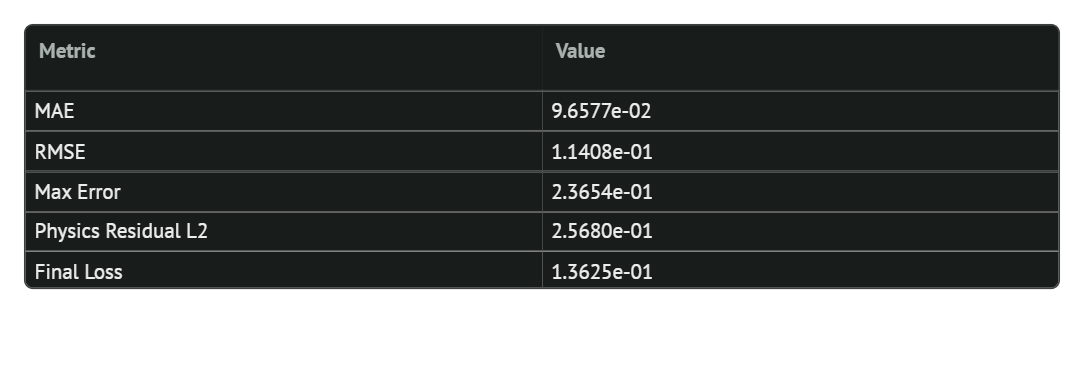

In [ ]:

if results['u_ref'] is not None:
    mae = np.mean(np.abs(results['u_pred'] - results['u_ref']))
    max_error = np.max(np.abs(results['u_pred'] - results['u_ref']))
    rmse = np.sqrt(np.mean((results['u_pred'] - results['u_ref'])**2))

    t_metrics = torch.linspace(0.0, t_max_slider.value, 1000, device=device).view(-1, 1)
    t_metrics.requires_grad_(True)
    res_metrics = physics_residual(results['model'], t_metrics, g_slider.value,
                                   l_slider.value, beta_slider.value)
    residual_l2 = torch.sqrt(torch.mean(res_metrics.detach()**2)).item()

    metrics_table = mo.ui.table([
        {"Metric": "MAE", "Value": f"{mae:.4e}"},
        {"Metric": "RMSE", "Value": f"{rmse:.4e}"},
        {"Metric": "Max Error", "Value": f"{max_error:.4e}"},
        {"Metric": "Physics Residual L2", "Value": f"{residual_l2:.4e}"},
        {"Metric": "Final Loss", "Value": f"{results['losses'][-1, 0]:.4e}"}
    ], selection=None)
else:
    metrics_table = mo.md("_Reference solution unavailable_")

metrics_table

### 3.5 Phase Portrait

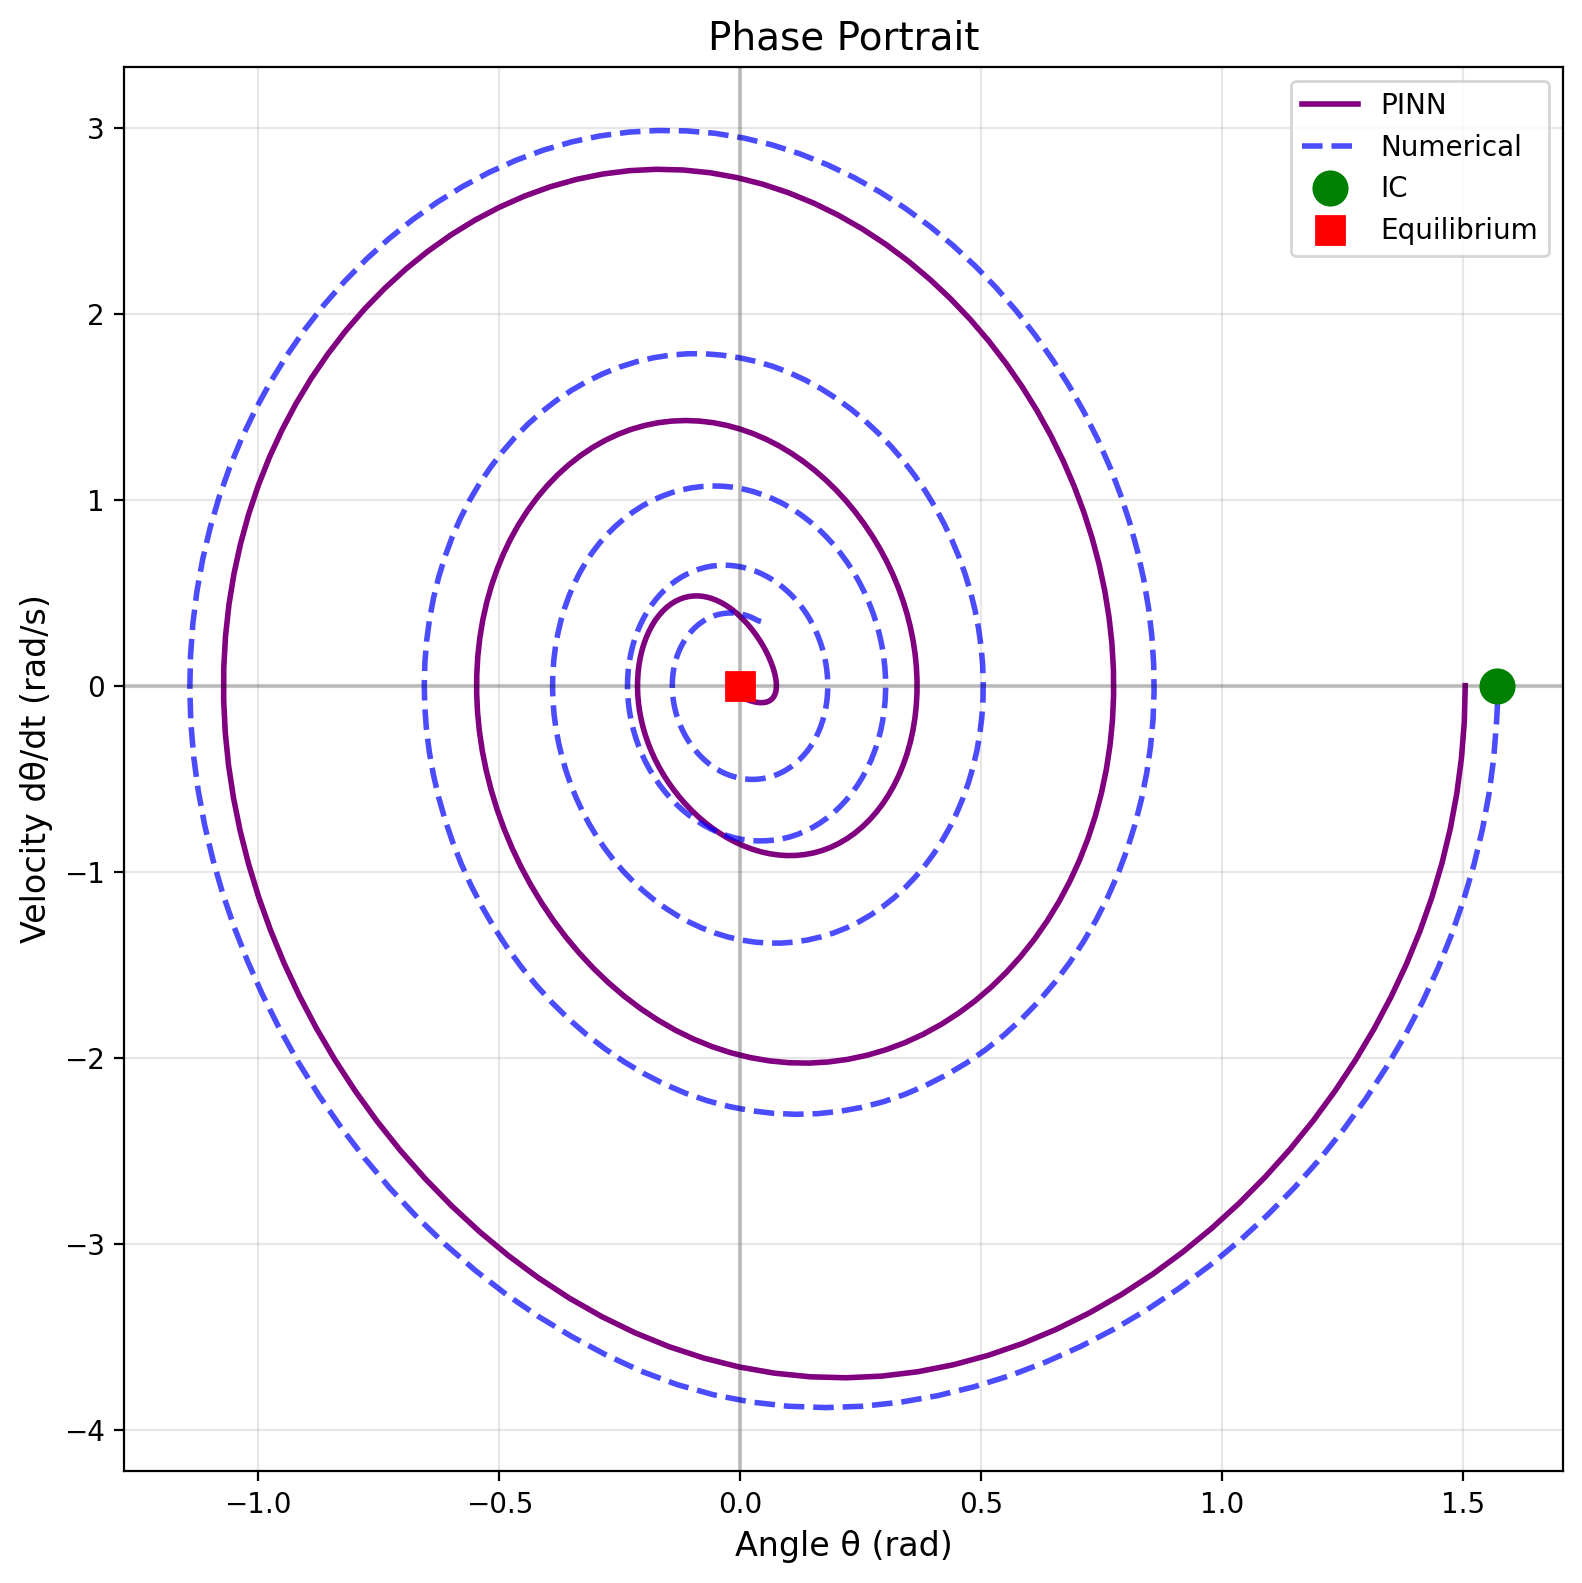

In [ ]:
t_phase = torch.linspace(0.0, t_max_slider.value, 500, device=device).view(-1, 1)
t_phase.requires_grad_(True)
u_phase = results['model'](t_phase)
u_dot = torch.autograd.grad(u_phase, t_phase, grad_outputs=torch.ones_like(u_phase),
                            create_graph=False)[0]

fig4, ax4 = plt.subplots(figsize=(8, 8))
ax4.plot(u_phase.cpu().detach().numpy(), u_dot.cpu().detach().numpy(),
        'purple', linewidth=2, label='PINN')

if results['u_ref'] is not None:
    u_dot_ref = np.gradient(results['u_ref'], results['t_ref'])
    ax4.plot(results['u_ref'], u_dot_ref, 'b--', linewidth=2, alpha=0.7, label='Numerical')

ax4.plot(u0_slider.value, v0_slider.value, 'go', markersize=12, label='IC', zorder=5)
ax4.plot(0, 0, 'rs', markersize=10, label='Equilibrium', zorder=5)
ax4.set_xlabel('Angle θ (rad)', fontsize=12)
ax4.set_ylabel('Velocity dθ/dt (rad/s)', fontsize=12)
ax4.set_title('Phase Portrait', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.axhline(0, color='k', linestyle='-', alpha=0.2)
ax4.axvline(0, color='k', linestyle='-', alpha=0.2)
plt.tight_layout()
fig4

### 3.6 Animated Pendulum Comparison

**Navy pendulum**: PINN prediction (red trace)
**Blue pendulum**: Numerical solution (cyan trace)

Watch how closely the two solutions match in real-time motion.

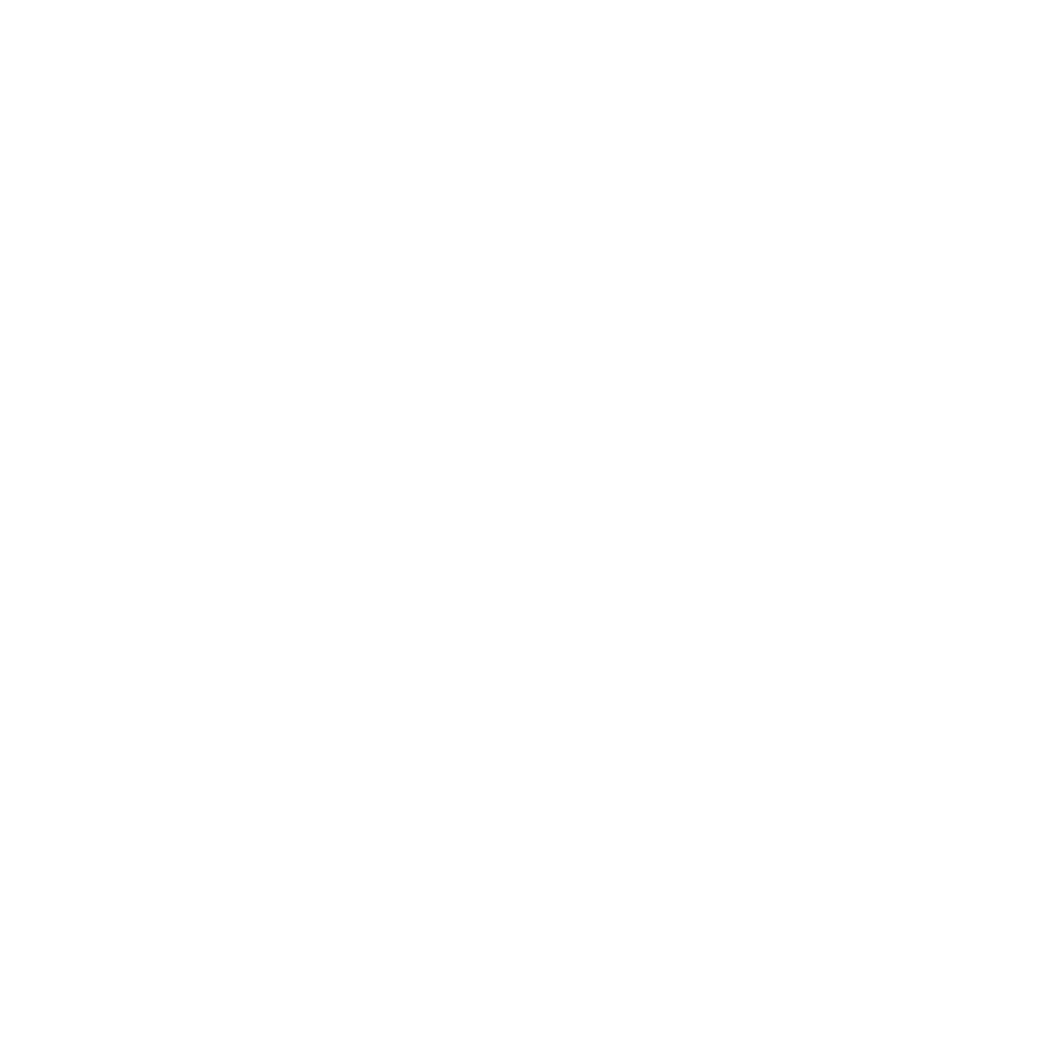

In [ ]:
if animation is not None:
    try:
        fig_anim, ax_anim = plt.subplots(figsize=(8, 8))
        ax_anim.set_xlim(-1.5 * l_slider.value, 1.5 * l_slider.value)
        ax_anim.set_ylim(-1.5 * l_slider.value, 0.5 * l_slider.value)
        ax_anim.set_aspect('equal')
        ax_anim.set_title('Pendulum Motion: PINN vs Numerical', fontsize=14)
        ax_anim.plot(0, 0, 'ko', markersize=8)

        # PINN pendulum (red/navy)
        line_pinn, = ax_anim.plot([], [], 'o-', linewidth=3, markersize=15, 
                                  color='navy', label='PINN')
        trace_pinn, = ax_anim.plot([], [], '-', alpha=0.3, linewidth=1, color='red')

        # Numerical pendulum (blue/cyan) - only if available
        if results['u_ref'] is not None:
            line_num, = ax_anim.plot([], [], 'o-', linewidth=3, markersize=15, 
                                    color='blue', alpha=0.7, label='Numerical')
            trace_num, = ax_anim.plot([], [], '-', alpha=0.3, linewidth=1, color='cyan')
            ax_anim.legend(loc='upper right')
            has_numerical = True
        else:
            line_num, trace_num = None, None
            has_numerical = False

        def init():
            line_pinn.set_data([], [])
            trace_pinn.set_data([], [])
            if has_numerical:
                line_num.set_data([], [])
                trace_num.set_data([], [])
                return line_pinn, trace_pinn, line_num, trace_num
            return line_pinn, trace_pinn

        def animate(i):
            # PINN solution
            angle_pinn = results['u_pred'][i]
            x_pinn = l_slider.value * np.sin(angle_pinn)
            y_pinn = -l_slider.value * np.cos(angle_pinn)
            line_pinn.set_data([0, x_pinn], [0, y_pinn])

            start = max(0, i - 20)
            trace_x_pinn = l_slider.value * np.sin(results['u_pred'][start:i+1])
            trace_y_pinn = -l_slider.value * np.cos(results['u_pred'][start:i+1])
            trace_pinn.set_data(trace_x_pinn, trace_y_pinn)

            if has_numerical:
                # Numerical solution
                angle_num = results['u_ref'][i]
                x_num = l_slider.value * np.sin(angle_num)
                y_num = -l_slider.value * np.cos(angle_num)
                line_num.set_data([0, x_num], [0, y_num])

                trace_x_num = l_slider.value * np.sin(results['u_ref'][start:i+1])
                trace_y_num = -l_slider.value * np.cos(results['u_ref'][start:i+1])
                trace_num.set_data(trace_x_num, trace_y_num)
                return line_pinn, trace_pinn, line_num, trace_num

            return line_pinn, trace_pinn

        anim = animation.FuncAnimation(fig_anim, animate, init_func=init,
                                      frames=len(results['u_pred']), interval=20, blit=True)

        # Convert to HTML5 video
        video_html = anim.to_html5_video()
        plt.close(fig_anim)

        animation_display = mo.Html(video_html)
    except Exception as e:
        animation_display = mo.md(f"_Animation error: {str(e)}_")
else:
    animation_display = mo.md("_Install matplotlib with: `pip install matplotlib`_")

animation_display

---
## Summary

**Strengths:** Meshfree, continuous, differentiable, physics-constrained

**Limitations:** Training cost, hyperparameter sensitivity

**Extensions:** Inverse problems, PDEs, multi-physics coupling, real-time control